In [1]:
!pip install fbprophet

In [2]:
import warnings
from sklearn.metrics import mean_absolute_error
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional
import re
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
Pop = pd.read_csv("/content/TM.csv")
Pop

,Date,prix moyen au kg,Production quantité \ntonne(s),Température minimale en °C,Température maximale en °C,précipitations en mm,Ensoleillement en min,Rafales (vitesse du vent) en km/h
0,21/06/21,1.50,0.200,15.7,24.9,3.8,423,61.2
1,04/12/20,1.50,0.100,2.9,6.6,0.8,256,65.9
2,06/11/20,1.10,0.100,2.3,13.4,0.0,491,46.8
3,05/11/20,1.10,0.100,1.8,11.5,0.0,533,32.4
4,30/10/20,1.05,0.100,12.6,15.9,0.0,0,40.7
...,...,...,...,...,...,...,...,...
419,24/06/13,1.10,1.120,10.5,19.1,0.0,342,42.6
420,20/06/13,1.50,0.075,14.0,21.5,0.8,216,37.1
421,17/06/13,1.50,0.020,15.0,27.2,6.8,210,61.1
422,18/09/12,1.10,0.180,10.3,20.1,0.0,126,34.2


**Pour le prix**

In [4]:
dfP = Pop[["Date","prix moyen au kg"]]
dfP

,Date,prix moyen au kg
0,21/06/21,1.50
1,04/12/20,1.50
2,06/11/20,1.10
3,05/11/20,1.10
4,30/10/20,1.05
...,...,...
419,24/06/13,1.10
420,20/06/13,1.50
421,17/06/13,1.50
422,18/09/12,1.10


In [5]:
dfP['ds'] = pd.to_datetime(dfP['Date'])
dfP['y'] = dfP['prix moyen au kg']
dfP = dfP.drop(["Date","prix moyen au kg"], axis=1)
dfP

,ds,y
0,2021-06-21,1.50
1,2020-04-12,1.50
2,2020-06-11,1.10
3,2020-05-11,1.10
4,2020-10-30,1.05
...,...,...
419,2013-06-24,1.10
420,2013-06-20,1.50
421,2013-06-17,1.50
422,2012-09-18,1.10


In [6]:
from fbprophet import Prophet
m1 = Prophet(daily_seasonality=True)
m1.fit(dfP)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [7]:
future1 = m1.make_future_dataframe(periods=7, freq='D')
predictions=m1.predict(future1)

In [8]:
predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
400,2021-06-22,1.775502,1.507194,2.039531
401,2021-06-23,1.760108,1.498302,2.032124
402,2021-06-24,1.727115,1.441457,2.010249
403,2021-06-25,1.724918,1.462964,1.996545
404,2021-06-26,1.769286,1.504949,2.021305
405,2021-06-27,1.713392,1.453056,2.001723
406,2021-06-28,1.682018,1.421047,1.962974


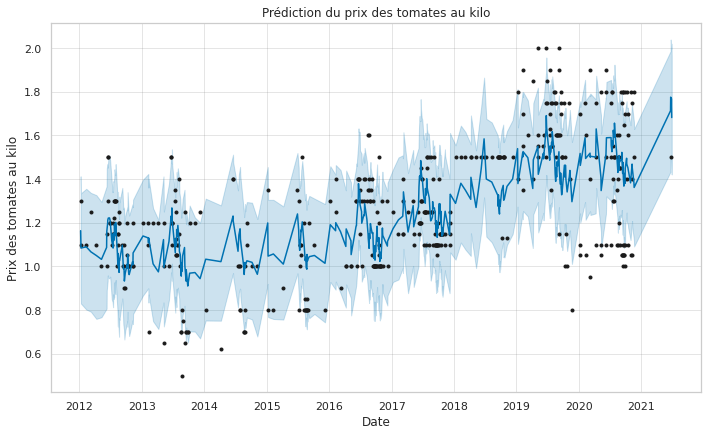

In [9]:
m1.plot(predictions)
plt.title("Prédiction du prix des tomates au kilo")
plt.xlabel("Date")
plt.ylabel("Prix des tomates au kilo")
plt.show()

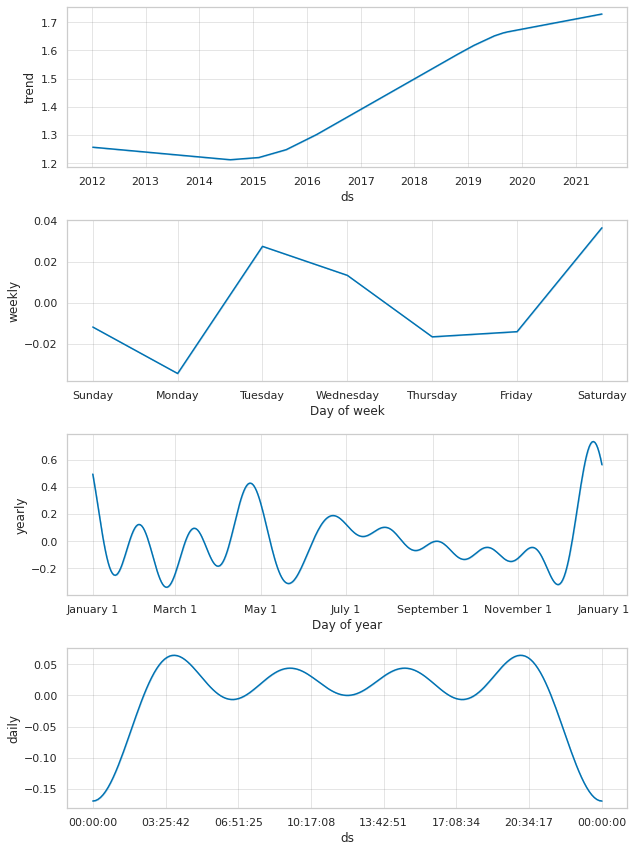

In [10]:
m1.plot_components(predictions)
plt.show()

In [11]:
metric_df = predictions.set_index('ds')[['yhat']].join(dfP.set_index('ds').y).reset_index()
metric_df

,ds,yhat,y
0,2012-01-08,1.163558,1.30
1,2012-01-10,1.083884,1.10
2,2012-02-10,1.089850,1.10
3,2012-03-08,1.066685,1.25
4,2012-04-09,1.049761,1.10
...,...,...,...
426,2021-06-24,1.727115,NaN
427,2021-06-25,1.724918,NaN
428,2021-06-26,1.769286,NaN
429,2021-06-27,1.713392,NaN


In [12]:
metric_df.dropna(inplace=True)
metric_df.tail()

,ds,yhat,y
419,2020-11-09,1.452055,1.05
420,2020-11-09,1.452055,1.75
421,2020-11-19,1.381428,1.80
422,2020-11-20,1.361638,1.50
423,2021-06-21,1.713015,1.50


In [13]:
from sklearn.metrics import mean_squared_error, r2_score
R2P = r2_score(metric_df.y, metric_df.yhat)
R2P

0.47427514009580973

In [14]:
from math import sqrt

rmseP =sqrt(mean_squared_error(metric_df.y, metric_df.yhat))
print(rmseP)

0.20875307512790345


In [15]:
mean_absolute_error(metric_df.y, metric_df.yhat)

0.1691008453972999

**Pour la production**

In [16]:
dfPo = Pop[["Date","Production quantité \ntonne(s)"]]
dfPo

,Date,Production quantité \ntonne(s)
0,21/06/21,0.200
1,04/12/20,0.100
2,06/11/20,0.100
3,05/11/20,0.100
4,30/10/20,0.100
...,...,...
419,24/06/13,1.120
420,20/06/13,0.075
421,17/06/13,0.020
422,18/09/12,0.180


In [17]:
dfPo['ds'] = pd.to_datetime(dfPo['Date'])
dfPo['y'] = dfPo['Production quantité \ntonne(s)']
dfPo = dfPo.drop(["Date","Production quantité \ntonne(s)"], axis=1)
dfPo

,ds,y
0,2021-06-21,0.200
1,2020-04-12,0.100
2,2020-06-11,0.100
3,2020-05-11,0.100
4,2020-10-30,0.100
...,...,...
419,2013-06-24,1.120
420,2013-06-20,0.075
421,2013-06-17,0.020
422,2012-09-18,0.180


In [18]:
m2 = Prophet(daily_seasonality=True)
m2.fit(dfPo)

In [19]:
future2 = m2.make_future_dataframe(periods=7, freq='D')
predictions2=m2.predict(future2)

In [20]:
predictions2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
400,2021-06-22,-0.392686,-1.260478,0.565753
401,2021-06-23,-0.130257,-0.994996,0.730452
402,2021-06-24,0.243371,-0.628348,1.150455
403,2021-06-25,-0.071364,-0.876794,0.810853
404,2021-06-26,0.205164,-0.716452,1.121013
405,2021-06-27,-0.046321,-0.948528,0.792520
406,2021-06-28,0.264896,-0.678090,1.122704


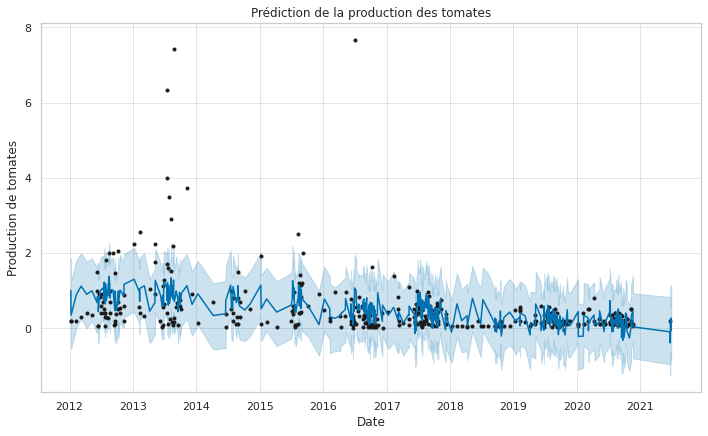

In [21]:
m2.plot(predictions2)
plt.title("Prédiction de la production des tomates")
plt.xlabel("Date")
plt.ylabel("Production de tomates")
plt.show()

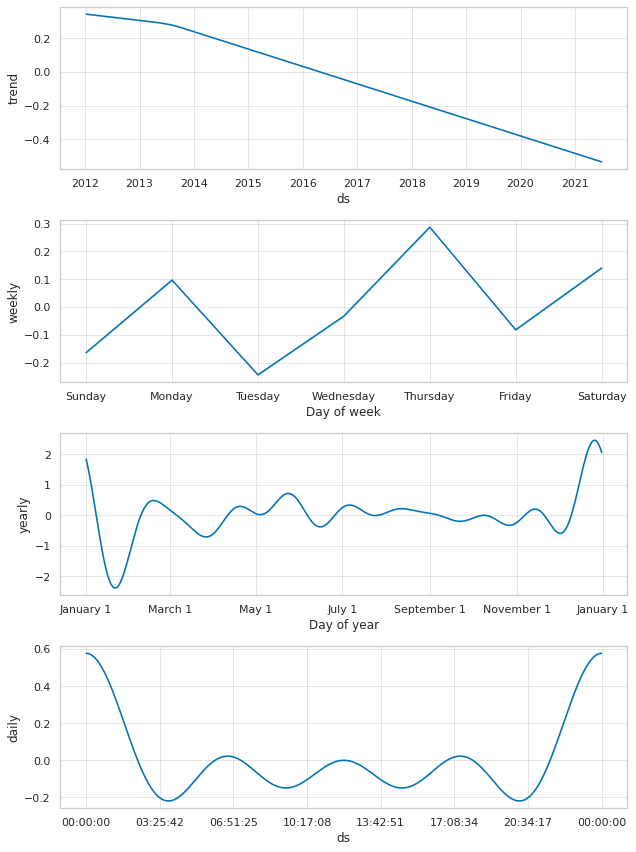

In [22]:
m2.plot_components(predictions2)
plt.show()

In [23]:
metric_df2 = predictions2.set_index('ds')[['yhat']].join(dfPo.set_index('ds').y).reset_index()
metric_df2

,ds,yhat,y
0,2012-01-08,1.005028,0.2
1,2012-01-10,0.345032,0.2
2,2012-02-10,0.898940,0.2
3,2012-03-08,1.117393,0.3
4,2012-04-09,0.899978,0.4
...,...,...,...
426,2021-06-24,0.243371,NaN
427,2021-06-25,-0.071364,NaN
428,2021-06-26,0.205164,NaN
429,2021-06-27,-0.046321,NaN


In [24]:
metric_df2.dropna(inplace=True)
metric_df2.tail()

,ds,yhat,y
419,2020-11-09,0.308435,0.50
420,2020-11-09,0.308435,0.50
421,2020-11-19,0.457726,0.05
422,2020-11-20,0.034232,0.10
423,2021-06-21,-0.099052,0.20


In [25]:
R2Po = r2_score(metric_df2.y, metric_df2.yhat)
R2Po

0.22980826559483647

In [26]:
rmsePo =sqrt(mean_squared_error(metric_df2.y, metric_df2.yhat))
print(rmsePo)

0.6809053931821226


In [27]:
mean_absolute_error(metric_df2.y, metric_df2.yhat)

0.36060988553766415

**Météo future**

In [28]:
#la température minimale

dfTm = Pop[["Date","Température minimale en °C"]]
dfTm

,Date,Température minimale en °C
0,21/06/21,15.7
1,04/12/20,2.9
2,06/11/20,2.3
3,05/11/20,1.8
4,30/10/20,12.6
...,...,...
419,24/06/13,10.5
420,20/06/13,14.0
421,17/06/13,15.0
422,18/09/12,10.3


In [29]:
dfTm['ds'] = pd.to_datetime(dfTm['Date'])
dfTm['y'] = dfTm['Température minimale en °C']
dfTm = dfTm.drop(["Date","Température minimale en °C"], axis=1)
dfTm

,ds,y
0,2021-06-21,15.7
1,2020-04-12,2.9
2,2020-06-11,2.3
3,2020-05-11,1.8
4,2020-10-30,12.6
...,...,...
419,2013-06-24,10.5
420,2013-06-20,14.0
421,2013-06-17,15.0
422,2012-09-18,10.3


In [30]:
m3 = Prophet(daily_seasonality=True)
m3.fit(dfTm)

In [31]:
future3 = m3.make_future_dataframe(periods=7, freq='D')
predictions3=m3.predict(future3)

In [32]:
predictions3[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
400,2021-06-22,14.523236,10.129175,18.969435
401,2021-06-23,15.556457,11.620772,19.919552
402,2021-06-24,14.459556,9.955152,18.907338
403,2021-06-25,14.773555,10.039528,19.188737
404,2021-06-26,12.883433,8.654310,17.565561
405,2021-06-27,12.839891,8.483560,17.630970
406,2021-06-28,13.268042,8.691259,17.728183


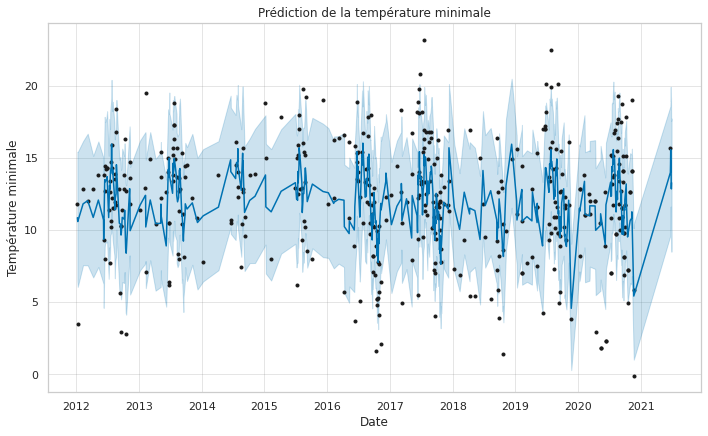

In [33]:
m3.plot(predictions3)
plt.title("Prédiction de la température minimale")
plt.xlabel("Date")
plt.ylabel("Température minimale")
plt.show()

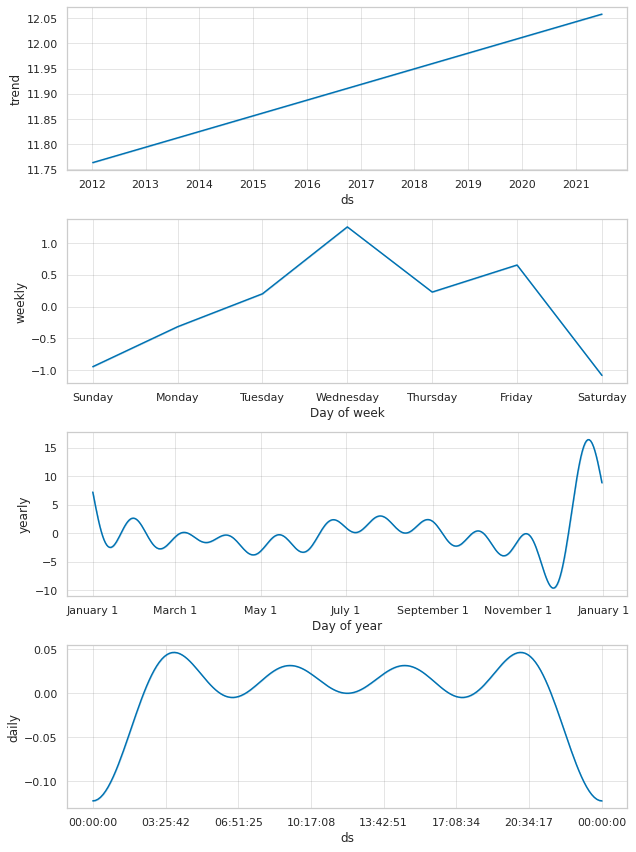

In [34]:
m3.plot_components(predictions3)
plt.show()

In [35]:
#température maximale

dfTM = Pop[["Date","Température maximale en °C"]]
dfTM

,Date,Température maximale en °C
0,21/06/21,24.9
1,04/12/20,6.6
2,06/11/20,13.4
3,05/11/20,11.5
4,30/10/20,15.9
...,...,...
419,24/06/13,19.1
420,20/06/13,21.5
421,17/06/13,27.2
422,18/09/12,20.1


In [36]:
dfTM['ds'] = pd.to_datetime(dfTM['Date'])
dfTM['y'] = dfTM['Température maximale en °C']
dfTM = dfTM.drop(["Date","Température maximale en °C"], axis=1)
dfTM

,ds,y
0,2021-06-21,24.9
1,2020-04-12,6.6
2,2020-06-11,13.4
3,2020-05-11,11.5
4,2020-10-30,15.9
...,...,...
419,2013-06-24,19.1
420,2013-06-20,21.5
421,2013-06-17,27.2
422,2012-09-18,20.1


In [37]:
m4 = Prophet(daily_seasonality=True)
m4.fit(dfTM)

In [38]:
future4 = m4.make_future_dataframe(periods=7, freq='D')
predictions4=m4.predict(future4)

In [39]:
predictions4[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
400,2021-06-22,27.750925,21.886087,33.732854
401,2021-06-23,28.496997,22.406791,34.655145
402,2021-06-24,26.349151,19.804457,32.454271
403,2021-06-25,25.467907,19.571727,31.268505
404,2021-06-26,25.891832,19.452101,31.701205
405,2021-06-27,24.446332,18.203036,30.650983
406,2021-06-28,26.284734,20.079830,32.610958


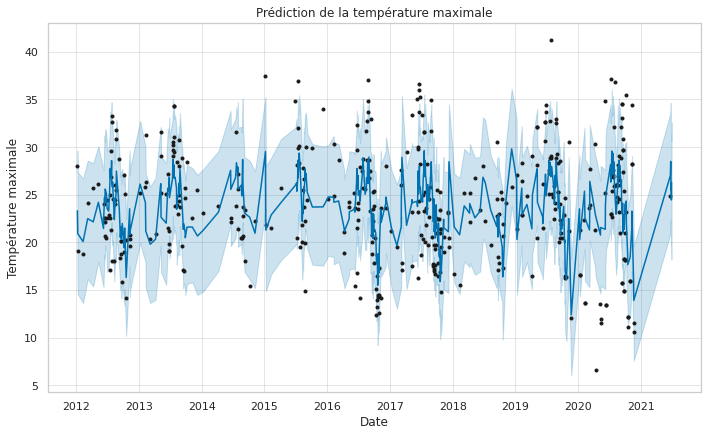

In [40]:
m4.plot(predictions4)
plt.title("Prédiction de la température maximale")
plt.xlabel("Date")
plt.ylabel("Température maximale")
plt.show()

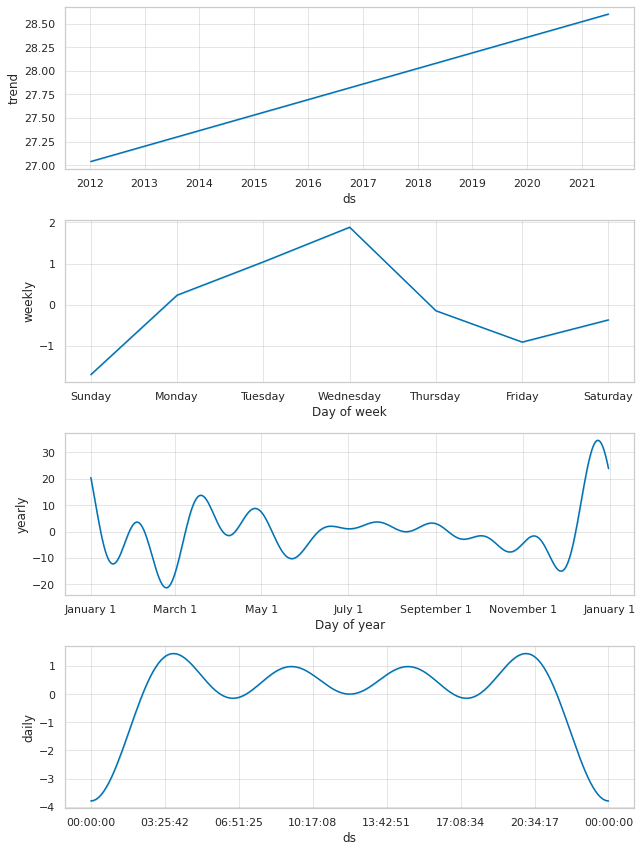

In [41]:
m4.plot_components(predictions4)
plt.show()

In [42]:
# les précipitations

dfp = Pop[["Date","précipitations en mm"]]
dfp

,Date,précipitations en mm
0,21/06/21,3.8
1,04/12/20,0.8
2,06/11/20,0.0
3,05/11/20,0.0
4,30/10/20,0.0
...,...,...
419,24/06/13,0.0
420,20/06/13,0.8
421,17/06/13,6.8
422,18/09/12,0.0


In [43]:
dfp['ds'] = pd.to_datetime(dfp['Date'])
dfp['y'] = dfp['précipitations en mm']
dfp = dfp.drop(["Date","précipitations en mm"], axis=1)
dfp

,ds,y
0,2021-06-21,3.8
1,2020-04-12,0.8
2,2020-06-11,0.0
3,2020-05-11,0.0
4,2020-10-30,0.0
...,...,...
419,2013-06-24,0.0
420,2013-06-20,0.8
421,2013-06-17,6.8
422,2012-09-18,0.0


In [44]:
m5 = Prophet(daily_seasonality=True)
m5.fit(dfp)

future5 = m5.make_future_dataframe(periods=7, freq='D')
predictions5=m5.predict(future5)

predictions5[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
400,2021-06-22,-0.748943,-6.136857,4.594845
401,2021-06-23,0.544994,-5.241378,5.852545
402,2021-06-24,0.783707,-4.263843,6.777619
403,2021-06-25,1.717775,-3.779268,7.244532
404,2021-06-26,0.398975,-4.995172,5.611306
405,2021-06-27,0.603485,-5.093079,5.929527
406,2021-06-28,-0.095513,-5.649782,5.078131


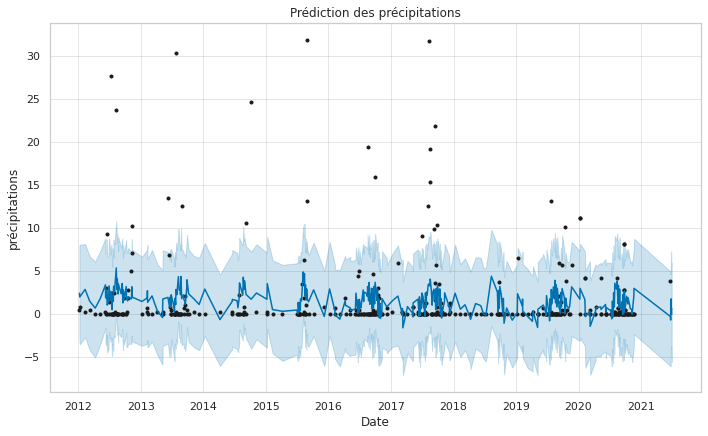

In [45]:
m5.plot(predictions5)
plt.title("Prédiction des précipitations")
plt.xlabel("Date")
plt.ylabel("précipitations")
plt.show()

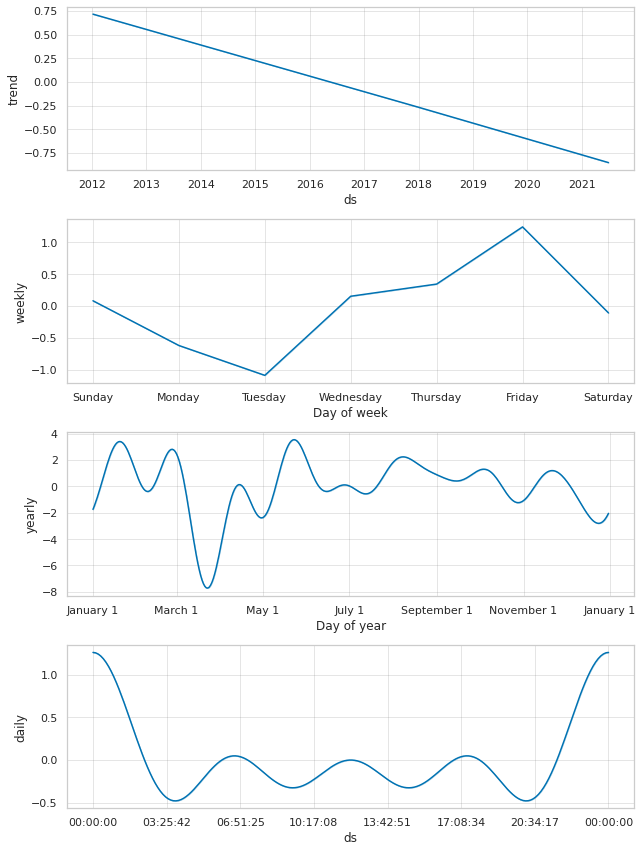

In [46]:
m5.plot_components(predictions5)
plt.show()

In [47]:
#ensoleillement

dfE = Pop[["Date","Ensoleillement en min"]]

dfE['ds'] = pd.to_datetime(dfE['Date'])
dfE['y'] = dfE['Ensoleillement en min']
dfE = dfE.drop(["Date","Ensoleillement en min"], axis=1)
dfE

,ds,y
0,2021-06-21,423
1,2020-04-12,256
2,2020-06-11,491
3,2020-05-11,533
4,2020-10-30,0
...,...,...
419,2013-06-24,342
420,2013-06-20,216
421,2013-06-17,210
422,2012-09-18,126


In [48]:
m6 = Prophet(daily_seasonality=True)
m6.fit(dfE)

future6 = m6.make_future_dataframe(periods=7, freq='D')
predictions6=m6.predict(future6)

predictions6[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
400,2021-06-22,578.860623,252.227535,881.143224
401,2021-06-23,577.989268,265.936750,923.579571
402,2021-06-24,519.106653,194.505588,819.540858
403,2021-06-25,483.341494,172.200628,799.182288
404,2021-06-26,607.245217,283.145650,931.737467
405,2021-06-27,439.553676,103.379857,775.736287
406,2021-06-28,526.113999,212.085865,837.036329


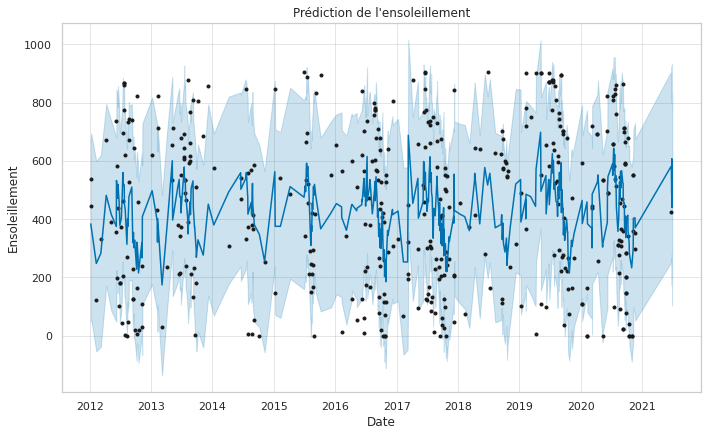

In [49]:
m6.plot(predictions6)
plt.title("Prédiction de l'ensoleillement")
plt.xlabel("Date")
plt.ylabel("Ensoleillement")
plt.show()

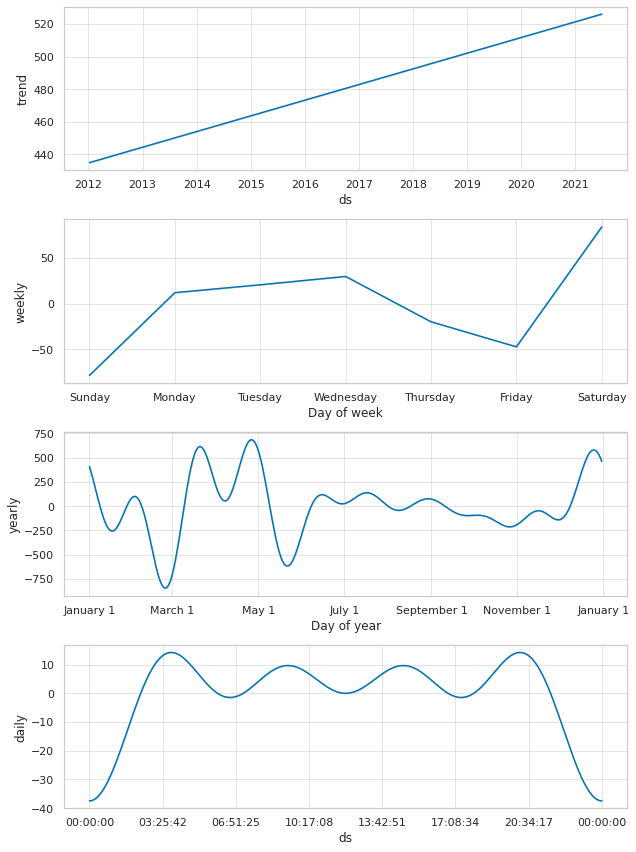

In [50]:
m6.plot_components(predictions6)
plt.show()

In [51]:
#vitesse du vent

dfV = Pop[["Date","Rafales (vitesse du vent) en km/h"]]

dfV['ds'] = pd.to_datetime(dfV['Date'])
dfV['y'] = dfV['Rafales (vitesse du vent) en km/h']
dfV = dfV.drop(["Date","Rafales (vitesse du vent) en km/h"], axis=1)
dfV

,ds,y
0,2021-06-21,61.2
1,2020-04-12,65.9
2,2020-06-11,46.8
3,2020-05-11,32.4
4,2020-10-30,40.7
...,...,...
419,2013-06-24,42.6
420,2013-06-20,37.1
421,2013-06-17,61.1
422,2012-09-18,34.2


In [52]:
m7 = Prophet(daily_seasonality=True)
m7.fit(dfV)

future7 = m7.make_future_dataframe(periods=7, freq='D')
predictions7=m7.predict(future7)

predictions7[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
400,2021-06-22,43.888893,29.454638,58.934611
401,2021-06-23,44.795234,29.699185,60.042999
402,2021-06-24,46.019861,31.110255,60.237318
403,2021-06-25,47.267584,32.021317,62.459413
404,2021-06-26,44.372679,28.503560,59.659441
405,2021-06-27,45.936105,29.606657,60.847359
406,2021-06-28,45.511336,30.979589,60.984177


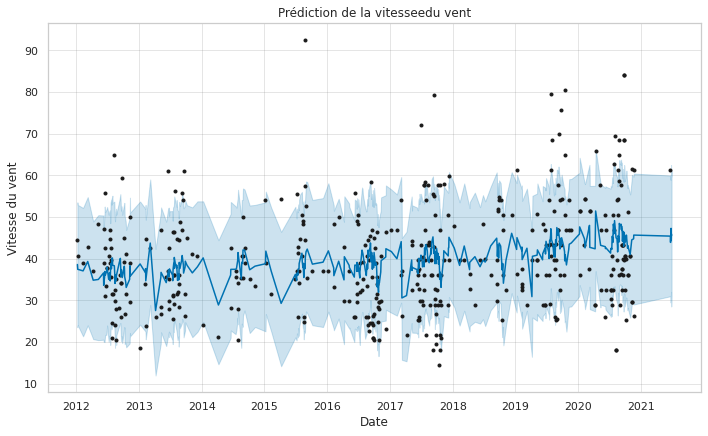

In [53]:
m7.plot(predictions7)
plt.title("Prédiction de la vitesseedu vent")
plt.xlabel("Date")
plt.ylabel("Vitesse du vent")
plt.show()

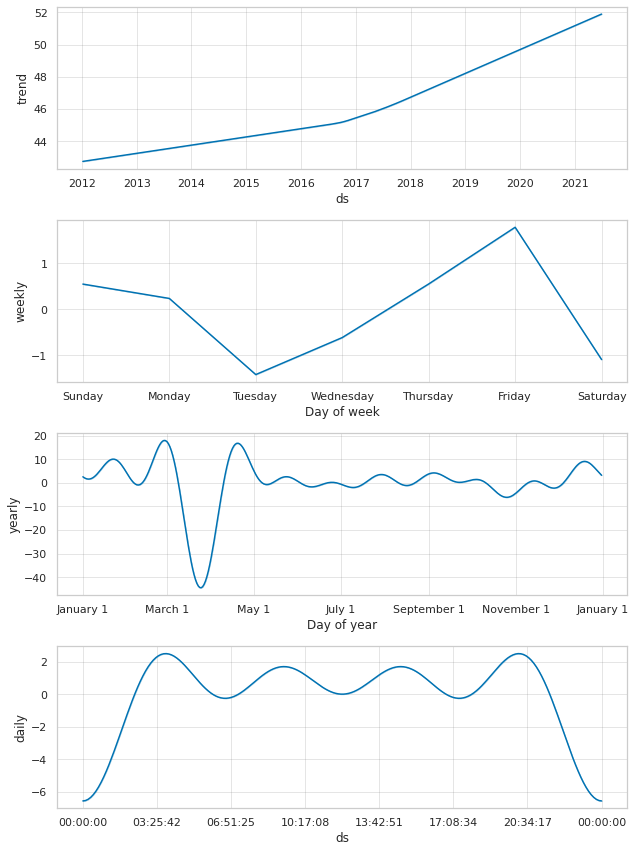

In [54]:
m7.plot_components(predictions7)
plt.show()

**Tableau récapitulatif des prédictions**

In [55]:
RTS={'Prix au kilo des tomates dans 7 jours':[1.776, 1.760, 1.727, 1.725, 1.769, 1.713, 1.682],
     'Production de tomates dans 7 jours' :[0.397, 0.134, 0.240, 0.074, 0.202, 0.050, 0.263],
     'Température minimale dans 7 jours': [14.5, 15.6, 14.6, 14.8, 12.9, 12.8, 13.3],
     'Température maximale dans 7 jours':[27.8, 28.5, 26.3, 25.5, 25.9, 24.4, 26.3],
     'Précipitations dans 7 jours':[0.7, 0.5, 0.8, 1.7, 0.4, 0.6, 0.1],
     'Ensoleillement dans 7 jours':[579, 578, 519, 483, 607, 440, 526],
     'Vitesse du vent dans 7 jours':[43.9, 44.8, 46, 47.3, 44.4, 45.9, 45.5]}
RTS

{'Ensoleillement dans 7 jours': [579, 578, 519, 483, 607, 440, 526],
 'Prix au kilo des tomates dans 7 jours': [1.776,
  1.76,
  1.727,
  1.725,
  1.769,
  1.713,
  1.682],
 'Production de tomates dans 7 jours': [0.397,
  0.134,
  0.24,
  0.074,
  0.202,
  0.05,
  0.263],
 'Précipitations dans 7 jours': [0.7, 0.5, 0.8, 1.7, 0.4, 0.6, 0.1],
 'Température maximale dans 7 jours': [27.8,
  28.5,
  26.3,
  25.5,
  25.9,
  24.4,
  26.3],
 'Température minimale dans 7 jours': [14.5,
  15.6,
  14.6,
  14.8,
  12.9,
  12.8,
  13.3],
 'Vitesse du vent dans 7 jours': [43.9, 44.8, 46, 47.3, 44.4, 45.9, 45.5]}

In [56]:
D = pd.DataFrame(RTS, index=['2021-06-22','2021-06-23','2021-06-24','2021-06-25','2021-06-26','2021-06-27','2021-06-28'])
D

,Prix au kilo des tomates dans 7 jours,Production de tomates dans 7 jours,Température minimale dans 7 jours,Température maximale dans 7 jours,Précipitations dans 7 jours,Ensoleillement dans 7 jours,Vitesse du vent dans 7 jours
2021-06-22,1.776,0.397,14.5,27.8,0.7,579,43.9
2021-06-23,1.760,0.134,15.6,28.5,0.5,578,44.8
2021-06-24,1.727,0.240,14.6,26.3,0.8,519,46.0
2021-06-25,1.725,0.074,14.8,25.5,1.7,483,47.3
2021-06-26,1.769,0.202,12.9,25.9,0.4,607,44.4
2021-06-27,1.713,0.050,12.8,24.4,0.6,440,45.9
2021-06-28,1.682,0.263,13.3,26.3,0.1,526,45.5


**Enregistrement du modèle pour la production**

In [57]:
import pickle

filename = 'modèle_prophet_Production.pkl'
pickle.dump(m2, open(filename, 'wb'))

In [58]:
modèle2 = pickle.load(open(filename, 'rb'))
modèle2